In [1]:
import pandas as pd
import numpy as np

In [2]:
guests = pd.read_excel("data/guests.xlsx", index_col=0)
guests.drop("guest", axis= 1, inplace = True)
guests = 1 - guests 
vec_discount = guests["discount"].values #converts the discount column to a vector

In [3]:
hotels = pd.read_excel("data/hotels.xlsx", index_col=0)
vec_prices = hotels["price"].values

In [4]:
preferences = pd.read_excel("data/preferences.xlsx", index_col=0)
preferences["guest"] = pd.to_numeric(preferences["guest"].str.replace('guest_','')) - 1
preferences["hotel"] = pd.to_numeric(preferences["hotel"].str.replace('hotel_','')) - 1
pref_pivoted = pd.pivot_table(preferences, index ='guest', columns ='hotel', values= "priority" , aggfunc="min") #it pivots the original dataframe to get to a matrix-like format
rank_matrix = pref_pivoted.rank(axis = 1, method="dense").values #reorders preferences

In [5]:
#This function creates a utility matrix from the ranked preferences matrix
def to_utility_matrix(rank_matrix):
  user_utility = []
  for row in rank_matrix:
    utility_values = np.linspace(start=1, stop= 0.1, num=len(set(row[~np.isnan(row)]))) #utility goes from 1 to 0.1 split evenly between preferences
    user_utility.append([utility_values[int(i)-1] if i == i else i for i in row ]) #i == i to check if i is not nan 
  return np.nan_to_num(np.array(user_utility), nan = 0)

In [6]:
utility_matrix = to_utility_matrix(rank_matrix)

In [7]:
# def print_output(res, guest_count, room_count, hotel_count, t):
#   res_avg = np.round_(np.array(res).mean(axis=0), 3)
#   print(f"With {t} iterations, on average we have: \n{res_avg[0]}/{guest_count} guests placed \n{res_avg[1]}/{room_count} rooms occupied \n{res_avg[2]}/{hotel_count} hotels occupied \n{res_avg[3]} total revenue \n{res_avg[4]} total satisfaction")

In [8]:
def results(choice_matrix, vec_prices=vec_prices, vec_discount=vec_discount, utility_matrix=utility_matrix):
  guests_placed = choice_matrix.sum(axis=1).sum()
  rooms_occupied = choice_matrix.sum(axis=0).sum()
  hotels_occupied = np.where(choice_matrix.sum(axis=0) > 0, 1, 0).sum()
  prices_matrix = vec_prices * choice_matrix #all 1s in the matrix will be replaced by that hotel's price
  discount_matrix = np.multiply(prices_matrix, vec_discount[:, np.newaxis]) #the room price is then discounted for each user
  revenue = discount_matrix.sum()
  utility = np.multiply(choice_matrix, utility_matrix).sum()
  return([guests_placed, rooms_occupied, hotels_occupied, revenue, utility])

In [9]:
def random_model(hotels, vec_prices, vec_discount, rank_matrix, t=1000):
  guest_count, room_count, hotel_count = rank_matrix.shape[0] , hotels["rooms"].sum(), rank_matrix.shape[1]
  least = min([guest_count, room_count])
  res = []
  vec_rooms = np.repeat(hotels["price"], hotels["rooms"]).index.values #Denormalized the dataframe by adding rows. This vec contains the hotel number as many times as its rooms 
  for _ in range(t):
    choice_matrix = np.zeros(rank_matrix.shape) #creates filled with zeros 4000 x 400
    random_rooms = np.random.choice(vec_rooms, least, replace=False ) #selects randomly 4000 rooms from all possible rooms
    choice_matrix[tuple(range(least)),tuple(random_rooms)] = 1 #assign 1 to all occupied rooms given their indices
    res.append(results(choice_matrix, vec_prices, vec_discount))
  return list(np.array(res).mean(axis=0))

In [10]:
def preference_model(hotels, vec_prices, rank_matrix):
  rank_matrix_filled, choice_matrix  = np.nan_to_num(rank_matrix), np.zeros(rank_matrix.shape) 
  rooms = hotels["rooms"].values
  for idx, row in enumerate(rank_matrix_filled):
    c = np.multiply(row, np.where(rooms > 0, 1, 0) ) #sets preferences values to 0 where there is no room availability
    try:
      user_choice = np.where(c == np.min(c[np.nonzero(c)]), 1, 0) #The minimum nonzero is converted to 1 and the rest to 0
      choice_matrix[(idx),] = user_choice
      rooms = rooms - user_choice #subtract 1 from the room availability where it's now occupied 
    except ValueError: #pass if array are all zeros
     pass
  return  results(choice_matrix)

In [18]:
def room_model(hotels,rank_matrix):

    pref_pivoted=pd.DataFrame(rank_matrix).T
    pref_pivoted["price"] = hotels["price"]
    pref_pivoted["rooms"] =  hotels["rooms"] #add a column with number of rooms per hotel
    h_rooms = pref_pivoted.sort_values(by=['rooms','price'], ascending=[False,True]) #sorted by number of rooms
    h_rooms = h_rooms.drop(columns=["rooms","price"]) # drop column with number of rooms
    #dup = h_rooms



    choice_matrix = np.zeros(rank_matrix.shape) 
    v = hotels["rooms"].values

    for i,r in h_rooms.iterrows():
        x = r.sort_values()
        x = x.dropna()
        c = x[:v[i]]
        for idx in c.index:
            choice_matrix[idx][i] = 1
            #dup.drop([idx], axis=1) ??????
            h_rooms.iloc[:][idx]= np.nan
        
        
        
        
    return  results(choice_matrix)

In [12]:
def price_model(hotels, rank_matrix):
    pref_pivoted = pd.DataFrame(rank_matrix).T 
    pref_pivoted["price"] = hotels["price"] #add a column with prices per hotel
    pref_pivoted["rooms"] = hotels["rooms"] #add a column with number of rooms per hotel
    pref_by_price = pref_pivoted.sort_values(by=['price', 'rooms'], ascending=[True, False]) #sorted by price and more rooms
    pref_by_price = pref_by_price.drop(columns=["rooms","price"]) #drop columns: price and rooms
    choice_matrix = np.zeros(rank_matrix.shape) #define matrix with zeros, same shape as rank_matrix
    free_rooms = hotels["rooms"].values #vector of rooms from dataset hotels
    
    for i, rows in pref_by_price.iterrows(): #for hotel with name i, consider the row of guests
        hotel_i = pd.DataFrame(rows.values, columns=['values']) #transforming the row in dataframe 
        hotel_i['index'] = hotel_i.index.values #consider the index of values
        hotel_i = hotel_i.dropna().sort_values(by=['values','index'])['index'] #soting
        guest4hotel_i = hotel_i[:free_rooms[i]].values #take values of guests for free rooms
        for name_guest in guest4hotel_i:
            choice_matrix[name_guest][i] = 1
            pref_by_price.iloc[:][name_guest]= np.nan
            
    return results(choice_matrix)

In [13]:
random_model(hotels, vec_prices, vec_discount, rank_matrix, t=1000)

[4000.0, 4000.0, 399.999, 640416.1391599989, 131.8851703428407]

In [14]:
preference_model(hotels, vec_prices, rank_matrix)

[3975.0, 3975.0, 400, 643597.5300000005, 3895.433198505531]

In [19]:
room_model(hotels, rank_matrix)

[4000.0, 4000.0, 343, 633445.5199999999, 3680.0579936329723]

In [16]:
price_model(hotels, rank_matrix)

[3990.0, 3990.0, 383, 578798.2299999997, 3685.490018624015]

In [49]:
random_model_results = random_model(hotels, vec_prices, vec_discount, rank_matrix, t=1000)
preference_model_results = preference_model(hotels, vec_prices, rank_matrix)
room_model_results = room_model(hotels, rank_matrix)
price_model_results = price_model(hotels, rank_matrix)

In [183]:
matr_resul=np.array([random_model_results, preference_model_results, room_model_results, price_model_results])
matr_resul

array([[4.00000000e+03, 4.00000000e+03, 3.99999000e+02, 6.40389230e+05,
        1.32253551e+02],
       [3.97500000e+03, 3.97500000e+03, 4.00000000e+02, 6.43597530e+05,
        3.89543320e+03],
       [4.00000000e+03, 4.00000000e+03, 3.43000000e+02, 6.33445520e+05,
        3.68005799e+03],
       [3.99000000e+03, 3.99000000e+03, 3.83000000e+02, 5.78798230e+05,
        3.68549002e+03]])

In [242]:
cl, ro, ho, re, de = [], [], [], [], []
for i in list(range(4)):
    cl.append(matr_resul[j][0])
    ro.append(matr_resul[j][1])
    ho.append(matr_resul[j][2])
    re.append(matr_resul[j][3])
    de.append(matr_resul[j][4])

In [243]:
cl

[3990.0, 3990.0, 3990.0, 3990.0]

In [232]:
clients = [matr_resul[0][0],matr_resul[1][0],matr_resul[2][0],matr_resul[3][0]]
rooms = [matr_resul[0][1],matr_resul[1][1],matr_resul[2][1],matr_resul[3][1]]
hotels = [matr_resul[0][2],matr_resul[1][2],matr_resul[2][2],matr_resul[3][2]]
revenue = [matr_resul[0][3],matr_resul[1][3],matr_resul[2][3],matr_resul[3][3]]
degree = [matr_resul[0][4],matr_resul[1][4],matr_resul[2][4],matr_resul[3][4]]

revenue       

[640389.2303300002, 643597.5300000005, 633445.5199999999, 578798.2299999997]

Text(0.5, 1.0, 'Degree of satisfaction')

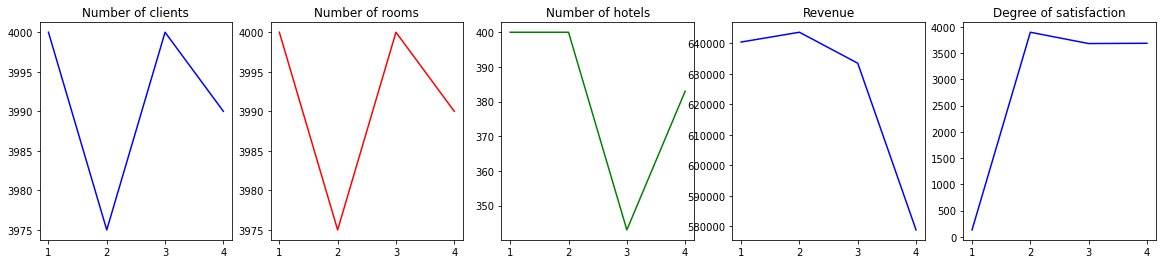

In [223]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
x = [1, 2, 3, 4]
y= []
#plt.scatter(x,y)
axes[0].plot(x, clients, 'b')
axes[0].set_title("Number of clients")
axes[1].plot(x, rooms, 'r')
axes[1].set_title("Number of rooms")
axes[2].plot(x, hotels, 'g')
axes[2].set_title("Number of hotels")
axes[3].plot(x, revenue, 'b')
axes[3].set_title("Revenue")
axes[4].plot(x, degree, 'b')
axes[4].set_title("Degree of satisfaction")

C:\Users\oanam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\Users\oanam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



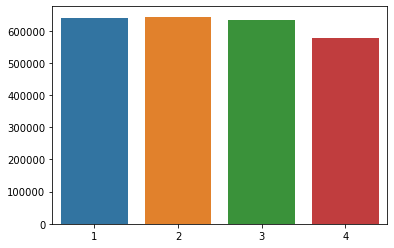

In [250]:
import seaborn as sns
sns.barplot(x, revenue)
sns.barplot(x, degree)
plt.show()

C:\Users\oanam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



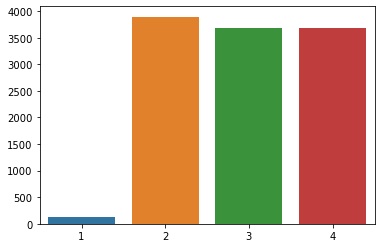

In [251]:
sns.barplot(x, degree)
plt.show()

In [58]:
row_label = ['Random Model', 'Preference Model', 'Availability Model', 'Price Model']
matr_row_label = np.array([row_label])
matr_row_label

array([['Random Model', 'Preference Model', 'Availability Model',
        'Price Model']], dtype='<U18')

In [25]:
import plotly.graph_objects as go

In [154]:
fig = go.Figure(data=[go.Table(
    header=dict(values=['Number of Clients arranged', 'Number of Rooms occupied', 'Number of Hotels', 'Revenue', 'Degree of satisfaction']),
    cells=dict(values=matr_resul.T))])
fig.show()

In [148]:
fig = go.Figure(data=[go.Table(
    header=dict(values=['Number of Clients arranged', 'Number of Rooms occupied', 'Number of Hotels', 'Revenue', 'Degree of satisfaction'],
                fill_color='light gray',
                align='left'),
    cells=dict(values=matr_resul.T,
               fill_color='lavender',
               align='left'))
])

fig.show()

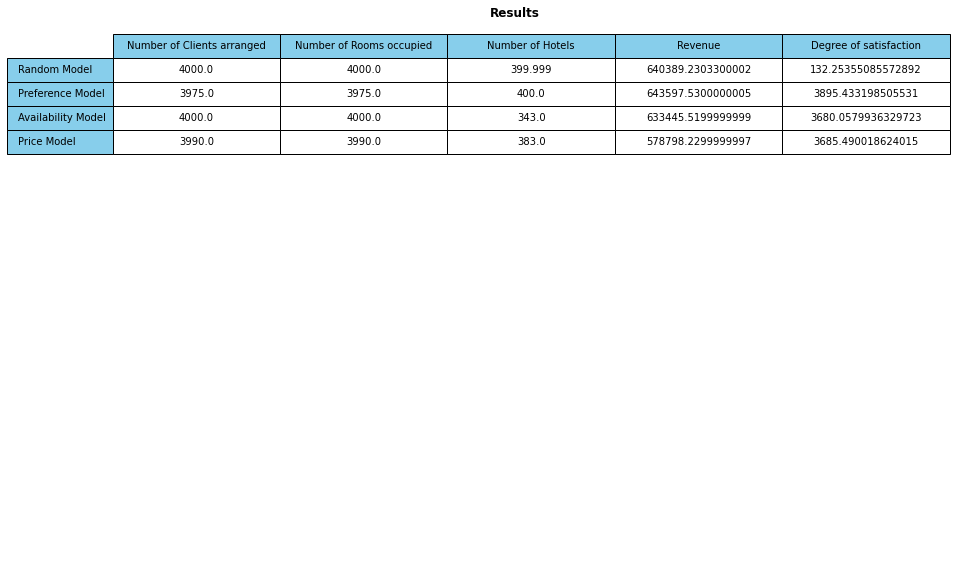

In [152]:
import matplotlib.pyplot as plt 
   
col_names = ['Number of Clients arranged', 'Number of Rooms occupied', 'Number of Hotels', 'Revenue', 'Degree of satisfaction'] 
row_names = ['Random Model', 'Preference Model', 'Availability Model', 'Price Model'] 
val = matr_resul
   
fig, ax = plt.subplots(figsize=(15,10)) 
ax.set_axis_off() 
table = ax.table( 
    cellText = val,  
    rowLabels = row_names,  
    colLabels = col_names, 
    rowColours =["skyblue"] * 10,  
    colColours =["skyblue"] * 10, 
    cellLoc ='center', loc ='upper left')

ax.set_title('Results', fontweight ="bold") 
table.scale(1, 2)
plt.show() 